In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

# Plot

In [2]:
#either dissonance measure or nr_partial (not both) can be a list for comparisson
def plot_dissonance(dissonance_measure, interval_range=(1,2),
                    base_freq = 261, fundamentals_vol = (1,1),
                    nr_partials = None, partials_pos = None, partials_vol = None,
                    scaling = None, labels = None):
    """Plots the dissonance curve of one or more given dissonance measures.
    A Dissonance curve plots the dissonance of two tones as a function of the interval they form, when one of 
    the tones stays fixed and the frequency of the other tone variesin a given range.

    A dissonance measure is a function that takes four lists of floats:
    fundamentals, fundamentals_vol, partials_pos, partials_vol
    and returns a float: The dissonance that results when a set of tones with volumes given in fundamentals_vol,
    and fundamental frequencies given in fundamentals sound together, where the tones are complexe tones with 
    partials at the positions given in partials_pos and intensities (relative to the total intensity of each 
    tone) given in partials_vol.

    Parameters
    ----------
    dissonance_measure: function or List of functions or np.Array of functions
        The dissonance measure to be plotted.
        If a list of dissonance measures is given, they are all plotted.
    interval_range: (float, float)
        the lower and higher margin of the interval range to be plotted
        where 1 is the unison, 2 the octave etc. (Default value = (1,2))
    base_freq: float
        The frequency of the fundamental of the fixed tone. (Default value = 261)
    fundamentals_vol: (float, float)
        The volume of both tones. (Default value = (1,1))
    nr_partials: None or int or list or range of ints
        The number of partials of the tones.
        If a list of ints is given, a plot is drawn for each number of partials.
        You can give a list as either dissonance_measure or nr_partials, not both.
        If None is given, nr_partials is set to 6.
        (Default value = None)
    partials_pos: None or list of floats
        The position of the partials of the complex sounds.
        E.g. [1,2] means the tones have to partials: the fundamental and an overtone at the octave.
        If None is given, partials_pos is set to [1,...,nr_partials] 
        i.e. the fundamental and the first nr_partials-1 harmonic overtones.
        (Default value = None)
    partials_vol: None or list of floats
        The volume of the partials of the complex tones.
        If None is given or the list is not long enough, partials_vol is set to
        [0.88^0,...,0.88^(nr_partials-1)], i.e. exponentially decreasing overtones.
        (Default value = None)
    scaling: None or list of floats
        The scaling of dissonance measures is arbitrary, for easier comparrisson when plotting,
        scaling factors can be given as a list.
        If None is given, scaling factors are all 1.
        (Default value = None)
    labels: None or list of Strings
        If a list of dissonance measures is given, a list of labels can be given to determine the 
        labels of the plots.
        If None is given, the measures are called Dissonance Measure 1, 2, 3, etc.    
    """
    
    if partials_pos is None:
        if isinstance(nr_partials, list) or isinstance(nr_partials, range):
            partials_pos = list(range(1, max(nr_partials) + 1)) # fundamental & harmonic overtones
            if partials_vol is None or len(partials_vol) < max(nr_partials):
                partials_vol = [0.88**i for i in range(max(nr_partials))] # Sethares 1993: 1219
        else:
            if nr_partials is None:
                nr_partials = 6
            partials_pos = list(range(1, nr_partials + 1)) # fundamental & harmonic overtones
            if partials_vol is None:
                partials_vol = [0.88**i for i in range(nr_partials)] # Sethares 1993: 1219
    
    intervals = np.arange(interval_range[0], interval_range[1], 0.005)
    
    fig, ax = plt.subplots()
    
    if isinstance(nr_partials, list) or isinstance(nr_partials, range):
        for nr in nr_partials:
            ax.plot(intervals, np.vectorize(
                lambda interval: dissonance_measure([base_freq, base_freq * interval], fundamentals_vol,
                                                      partials_pos[:nr], partials_vol[:nr])
            )(intervals), label='%i partials' % nr)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    elif isinstance(dissonance_measure, list) or isinstance(dissonance_measure, np.ndarray):
        if scaling is None or len(scaling) < len(dissonance_measure):
            scaling = [1 for _ in dissonance_measure]
        
        if labels is None or len(labels) < len(dissonance_measure):
            labels = ['Dissonance Measure %i' % i for i in range(1, len(dissonance_measure) + 1)]
        
        for i in range(len(dissonance_measure)):
            diss = dissonance_measure[i]
            ax.plot(intervals, np.vectorize(
                lambda interval: diss([base_freq, base_freq * interval], fundamentals_vol,
                                      partials_pos, partials_vol) * scaling[i]
            )(intervals), label=labels[i])
        ax.legend()
    else:
        ax.plot(intervals, np.vectorize(
            lambda interval: dissonance_measure([base_freq, base_freq * interval], fundamentals_vol,
                                                 partials_pos, partials_vol)
        )(intervals))
        
        if labels is not None:
            ax.legend([labels[0]])
    
    
    # reference intevals for the grid:
    reference_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]  # Just Intonation
    #reference_intervals = [2**(i/12) for i in range(0,13)]  # Equal Temperament
    degree_names = ['u', 'm2', 'M2', 'm3', 'M3', '4', 't', '5', 'm6', 'M6', 'm7', 'M7', 'o']
    
    # take only the ticks that I need
    needed_intervals = [i >= interval_range[0] and i <= interval_range[1] for i in reference_intervals]
    
    ax.set_xticks(np.array(reference_intervals)[needed_intervals])
    ax.set_xticklabels(np.array(degree_names)[needed_intervals])
    ax.xaxis.grid(True)
    plt.show()

# Basic Dissonance

In [3]:
# The basic dissonance meassure I decided on in the notebook "dissonance measures"

def additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, basic_dissonance):
    return sum([
        basic_dissonance(
            fundamentals[i] * partials_pos[k],
            fundamentals[j] * partials_pos[l],
            fundamentals_vol[i] * partials_vol[k],
            fundamentals_vol[j] * partials_vol[l]
        )
        for (i,j) in [(i,j) for i in range(len(fundamentals)) for j in range(i + 1, len(fundamentals))]
        for (k,l) in [(k,l) for k in range(len(partials_pos)) for l in range(len(partials_pos))]
    ])


def frankenstein_basic_dissonance(p1, p2, v1, v2):
    mean = (p1 + p2) / 2
    critical_bandwidth = 25 + 75 * (1 + 1.4e-6 * mean**2)**0.69  # taken from Dillon
    h = abs(p1 - p2) / critical_bandwidth
    
    if h >= 1.2:
        return 0
    
    d = 4.906 * h * (1.2 - h)**4  # taken from Dillon

    # translate v1, v2 to phon, similar to what I used in my Bernini implementation
    # but simplified and optimized (see Component Evaluation)
    # f much simpler
    v1 = np.log(1 + v1**8.685889 * np.exp(86 - 914.327 * p1**-0.8 - 1e-15 * p1**4))
    v2 = np.log(1 + v2**8.685889 * np.exp(86 - 914.327 * p2**-0.8 - 1e-15 * p2**4))
    f = v1 * v2
    
    return d * f


def frankenstein_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol,
                               frankenstein_basic_dissonance)


# Vectorized Dissonance

In [4]:
# same function as frankenstein_dissonance but with np.arrays instead of for-loops
def frankenstein_dissonance_vec(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    
    # a row corresponds to a complex tone
    positions = np.outer(fundamentals, partials_pos)
    volumes = np.outer(fundamentals_vol, partials_vol)
    
    # all pairs of partials and their volumes
    # including for every two partials only one pair
    # a partial does not form a pair with itself
    args = np.array([
        [positions[i,k],
        positions[j,l],
        volumes[i,k],
        volumes[j,l]]
        for (i,j) in [(i,j) for i in range(len(fundamentals)) for j in range(i + 1, len(fundamentals))]
        for (k,l) in [(k,l) for k in range(len(partials_pos)) for l in range(len(partials_pos))]
    ])  
    
    p1s = args[:,0]
    p2s = args[:,1]
    v1s = args[:,2]
    v2s = args[:,3]
    
    means = (p1s + p2s)/2
    critical_bandwidths = 25 + 75 * (1 + 1.4e-6 * means**2)**0.69
    hs = np.abs(p1s - p2s) / critical_bandwidths
    
    cond = np.where(hs < 1.2)
    hs = hs[cond]
    p1s = p1s[cond]
    p2s = p2s[cond]
    v1s = v1s[cond]
    v2s = v2s[cond]
    
    ds = 4.906 * hs * (1.2 - hs)**4
    
    v1s = np.log(1 + v1s**8.685889 * np.exp(86 - 914.327 * p1s**-0.8 - 1e-15 * p1s**4))
    v2s = np.log(1 + v2s**8.685889 * np.exp(86 - 914.327 * p2s**-0.8 - 1e-15 * p2s**4))
    fs = v1s * v2s
    
    return np.sum(ds * fs)


# Dissonance optimized for Optimization

## Preparation

Since, for reasons of harmonic and melodic integrity, I don't change fundamental frequencies more than 1/2 semitone during optimization, there are bounds to the maximal amount of change that could happen to some of the values I need to compute in every iteration during optimization: the critical bandwidth at the mean frequency of each pair, the relative distance (h) of each pair of frequencies, the relative loudness (in phon).

If that change is small enough, I could compute that values once before optimization and treat them as constants during optimization which reduces the complexity of the objective function and the gradient and reduces the computation time significantly.

In [13]:
# critical bandwidth
def cbw(f):
    return 25 + 75 * (1 + 1.4e-6 * f**2)**0.69

# max relative error of cbw of two partials 7 (ET-)semitones apart if we would fix it
# as a function of the frequency of the lower partial
def cbw_sensitivity(f):
    interval = 2**(7/12)
    mean1 = (f + f * interval) / 2
    e = 2**(1/24)  # 1/2 semitone
    mean2 = (f * e + f * interval / e) / 2
    return (cbw(mean1) - cbw(mean2)) / cbw(mean1)

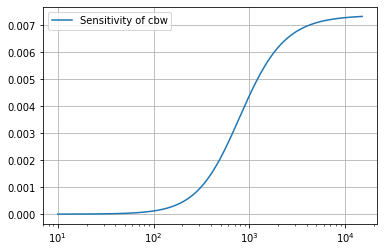

In [14]:
freqs = np.logspace(np.log2(10), np.log2(15000), num=1000, base=2)
fig, ax = plt.subplots()
ax.plot(freqs, np.vectorize(cbw_sensitivity)(freqs), label='Sensitivity of cbw')
ax.set_xscale('log')
ax.legend()
ax.grid(True)

In [15]:
def rel_distance(f1, f2):
    return np.abs(f1 - f2) / cbw((f1+f2)/2)

# max error of relative distance (h) of two partials 1.4*cbw apart
# if we would fix it as a function of the frequency of the lower partial
# as we see in the graph, two partials that are more than a 1.4*cbw apart,
# can never during the optimization process get so close together, that 
# their relative distance gets < 1.2, hence their roughness will allways
# be zero (with Dillon)!
def rel_distance_sensitivity(f):
    interval = 1.4*cbw(f)
    e = 2**(1/24)  # 1/2 semitone
    return abs(rel_distance(f, f * interval) - rel_distance(f * e, f * interval / e))

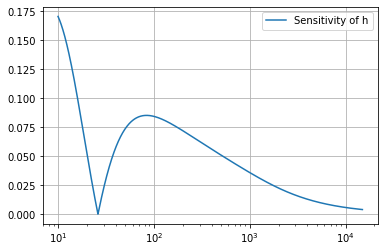

In [16]:
freqs = np.logspace(np.log2(10), np.log2(15000), num=1000, base=2)
fig, ax = plt.subplots()
ax.plot(freqs, np.vectorize(rel_distance_sensitivity)(freqs), label='Sensitivity of h')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()
ax.grid(True)

In [17]:
def phon(v, f):
    return np.log(1 + v**8.685889 * np.exp(86 - 914.327 * f**-0.8 - 1e-15 * f**4))

# max relative error of phon if we fix phon during the optimization
def phon_sensitivity(f):
    e = 2**(1/24)  # 1/2 semitone 
    return abs(phon(1,f) - phon(1,f*e)) / phon(1,f)

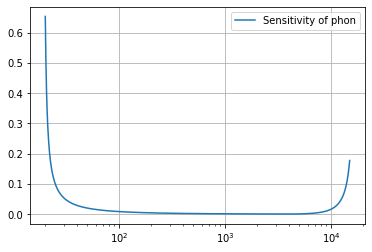

In [18]:
freqs = np.logspace(np.log2(20), np.log2(15000), num=1000, base=2)
fig, ax = plt.subplots()
ax.plot(freqs, np.vectorize(phon_sensitivity)(freqs), label='Sensitivity of phon')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()
ax.grid(True)

## Definition

In [19]:
# changes to make the optimization more efficient:
# also: new option to take fixed frequencies into account

# the phon values of the partials depend on the frequency of the partials,
# but during the optimization the changes frequencies are so small that the changes in phon can be neglected
# -> calculate phon (better: the volume factor f which is just the product of the phons)
# once and treat it as a constant during optimization
# same goes for the bandwidth

def quasi_constants(fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos, fixed_vol):
    # a row corresponds to a complex tone
    positions = np.outer(fundamentals, partials_pos)
    volumes = np.outer(fundamentals_vol, partials_vol)
    
    # all pairs of partials and their volumes
    # including for every two partials only one pair
    # a partial does not form a pair with itself
    args = np.array([
        [i, k, j, l,
        positions[i,k],
        positions[j,l],
        volumes[i,k],
        volumes[j,l]]
        for (i,j) in [(i,j) for i in range(len(fundamentals)) for j in range(i + 1, len(fundamentals))]
        for (k,l) in [(k,l) for k in range(len(partials_pos)) for l in range(len(partials_pos))]
    ] + [[i, k, f, -1,
        positions[i,k],
        fixed_pos[f],
        volumes[i,k],
        fixed_vol[f]]
        for i in range(len(fundamentals))
        for k in range(len(partials_pos))
        for f in range(len(fixed_pos))
    ])
    
    ids = args[:,0:4]
    p1s = args[:,4]
    p2s = args[:,5]
    v1s = args[:,6]
    v2s = args[:,7]
    
    means = (p1s + p2s)/2
    critical_bandwidths = 25 + 75 * (1 + 1.4e-6 * means**2)**0.69
    
    hs = np.abs(p1s - p2s) / critical_bandwidths
    cond = np.where(hs < 1.4) #todo nur zum test, eig 1.4
    critical_bandwidths = critical_bandwidths[cond]
    relevant_pairs = ids[cond].astype(int)
    p1s = p1s[cond]
    p2s = p2s[cond]
    v1s = v1s[cond]
    v2s = v2s[cond]
    
    v1s = np.log(1 + v1s**8.685889 * np.exp(86 - 914.327 * p1s**-0.8 - 1e-15 * p1s**4))
    v2s = np.log(1 + v2s**8.685889 * np.exp(86 - 914.327 * p2s**-0.8 - 1e-15 * p2s**4))
    volume_factors = v1s * v2s
    
    return critical_bandwidths, volume_factors, relevant_pairs


def frankenstein_dissonance_opt(fundamentals, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs):
    # frequencies of fundamentals are given in absolute values (Hz) in fundamentals
    # frequencies of partials are given relative the the fundamental frequency
    # e.g. [1,2] means that the complex tones are made up of 2 partials: the fundamental and the octave
    # fixed pos are theabsolute freqs of the fixed simple tones
    
    # a row corresponds to a complex tone
    positions = np.outer(fundamentals, partials_pos)
    
    # all relevant pairs of frequencies of partials
    args = np.array([
        [positions[i,k], positions[j,l]] if l >= 0 else [positions[i,k], fixed_pos[j]]
        for (i, k, j, l) in relevant_pairs
    ]) 
    
    p1s = args[:,0]
    p2s = args[:,1]
    
    hs = np.abs(p1s - p2s) / critical_bandwidths
    
    cond = np.where(hs < 1.2)
    hs = hs[cond]
    volume_factors = volume_factors[cond]
    
    ds = 4.906 * hs * (1.2 - hs)**4
    
    return np.sum(ds * volume_factors)

In [21]:
# test
# cutting pairs with h so big that they will never be relevant during optimization reduces
# the number of pairs in this example (tonic and fifth) from 121 to 20,
# in another more dense example (0, 4, 7, 12) from 726 to 133

# since, other than Dillon, Hutchinsons roughness is not exactly zero for hs > 1.2,
# this introduces a small but neglectable error

partials_vol_piano = np.array([3.7, 5.4, 1.2, 1.1, 0.95, 0.6, 0.5, 0.65, 0.001, 0.1, 0.2]) / 5.4

notes = [0, 4, 7, 12]
fundamentals = [440 * 2**(i/12) for i in notes]
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_piano
relative_bounds = (2**(-1/36), 2**(1/36))

fixed_pos = [fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]

critical_bandwidths, volume_factors, relevant_pairs = quasi_constants(fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol)

In [22]:
len(relevant_pairs)

133

In [23]:
def optimize(fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos = [], fixed_vol = [],
             method = "SLSQP", relative_bounds = (2**(-1/36), 2**(1/36)), maxiter = None):
    
    critical_bandwidths, volume_factors, relevant_pairs = quasi_constants(
        fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos, fixed_vol)
    
    bounds = [(f * relative_bounds[0], f * relative_bounds[1]) for f in fundamentals]
    if maxiter is None:
        options = {}
    else:
        options = {'maxiter': maxiter}
    
    res = scipy.optimize.minimize(
        lambda fs: frankenstein_dissonance_opt(
            fs, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs),
        fundamentals,
        method=method,
        bounds=bounds,
        options=options
    )
    
    return res

# Dillon Gradients

## Preparation

Let $C$ be a set of complex tones, each with partials $P$. Every complex tone $i \in C$ consists of partials $k \in P$, i.e. simple tones with frequency $f_{i,k}$ and amplitude $a_{i,k}.$

The total dissonance of complex tones $C$ with overtones $P$ is given by:

$D(C,P) = \sum_{i < j \in C} \sum_{k,l \in P} d_{i,j,k,l} v_{i,j,k,l}$

with basic dissonance factor (roughness of two simple tones):

$d_{i,j,k,l} = \begin{cases} 4.906 h_{i,j,k,l} (h_{i,j,k,l} - 1.2)^4 & h \le 1.2 \\ 0 & h_{i,j,k,l} > 1.2 \end{cases}$

where $h_{i,j,k,l}$ is the distance of the simple tones relative to the critical bandwidth:

$h_{i,j,k,l} = \frac{|f_{i,k} - f_{j,l}|}{cbw_{i,j,k,l}}$

where $cbw_{i,j,k,l}$ is an approximation of the critical bandwidth at the mean frequency:

$cbw_{i,j,k,l} = 25 + 75 (1 + 1.4*10^{-6} (\frac{f_{i,k}+f_{j,l}}{2})^2)^{0.69}$

and volume factor:

$v_{i,j,k,l} = p_{i,k}p_{j,l}$

where $p_{i,k}$ is an approximation of the subjective loudness in phon of the partial $k$ of complex tone $i$:

$p_{i,k} = \log(1+a_{i,k}^{8.685889}\exp(89 - 914.327 f_{i,k}^{-0.8} - 10^{-15} * f_{i,k}^4))$

Let $c \in C$ be some complex tone with partials with frequency $f_{c,j} = f_c r_j$ for $j \in P$, $f_c$ is the fundamental frequency of the complex tone, $r_j$ is the relative position of the partial $j$.

The partial derivative of $D$ with respect to $f_c$ is given by:

$\frac{\delta}{\delta f_c}D = \sum_{j \ne c \in C} \sum_{k,l \in P} \frac{\delta}{\delta f_c}(d_{c,j,k,l}v_{c,j,k,l})$

Since we consider the loudness $v_{c,j,k,l}$ to be constant during optimization, $\frac{\delta}{\delta f_c}(d_{c,j,k,l}v_{c,j,k,l}) = v_{c,j,k,l}\frac{\delta}{\delta f_c}d_{c,j,k,l}$.

Since $\lim_{h_{c,j,k,l} \nearrow 1.2} \frac{\delta}{\delta f_c}d_{c,j,k,l} = \lim_{h_{c,j,k,l} \searrow 1.2} \frac{\delta}{\delta f_c}d_{c,j,k,l} = 0$, $\frac{\delta}{\delta f_c}d_{c,j,k,l}$ is continuously differentiable (with respect to $h$) and the derivative is given by:

$\frac{\delta}{\delta f_c}d_{c,j,k,l} = \begin{cases} 4.906 (h_{c,j,k,l} - 1.2) (5 h_{c,j,k,l} - 1.2) \frac{\delta}{\delta f_c} h_{c,j,k,l} & h_{c,j,k,l} \le 1.2 \\ 0 & h_{c,j,k,l} > 1.2 \end{cases}$

Since $|x|$ is not differentiable at $x = 0$, $h_{c,j,k,l}$ isn't. If we choose the common $\frac{\delta}{\delta x} |x| := sgn(x)$, and consider $cbw_{c,j,k,l}$ to be constant during optimization, we get:

$\frac{\delta}{\delta f_c} h_{c,j,k,l} = \begin{cases} \frac{-1}{cbw_{c,j,k,l}} \frac{\delta f_{c,j}}{\delta f_c} & f_{c,k} < f_{c,k} \\ 0 & f_{c,k} = f_{c,k} \\ \frac{1}{cbw_{c,j,k,l}} \frac{\delta f_{c,j}}{\delta f_c} & f_{c,k} > f_{c,k} \end{cases}$

And finally:

$\frac{\delta}{\delta f_c} f_{c,j} = r_j$

Hence the gradient of the total dissonance $D$ with respect to the vector of complex tones $C = \{1, \ldots , n\}$ is given by:

$\nabla_C D = (\frac{\delta D}{\delta f_{1,j}},\ldots,\frac{\delta D}{\delta f_{n,j}})^T$

In [24]:
def simple_grad(f1, f2, critical_bandwidth, volume_factor):
    if f1 > f2:
        dhdf1 = 1 / critical_bandwidth
    elif f2 > f1:
        dhdf1 = -1 / critical_bandwidth
    else:
        return 0.
    
    h = abs(f1 - f2) / critical_bandwidth
    if h >= 1.2:
        return 0.
    else:
        dddf1 = 4.906 * (h - 1.2)**3 * (5 * h - 1.2) * dhdf1
    
    return dddf1 * volume_factor

In [25]:
# check if my gradient is correct:

f1 = 500
f2 = 440
volume_factor = phon(1, f1) * phon(1, f2)
critical_bandwidth = cbw((f1 + f2) / 2)

func = lambda f: frankenstein_basic_dissonance(f[0], f2, 1, 1)
grad = lambda f: simple_grad(f[0], f2, critical_bandwidth, volume_factor)

epsilon = 0.0000001

print("Dissonance:    ", frankenstein_basic_dissonance(f1, f2, 1, 1))
print("Gradient:      ", simple_grad(f1, f2, critical_bandwidth, volume_factor))
print("Approx Gradient", scipy.optimize.approx_fprime([f1], func, epsilon=epsilon))
print("Error          ", scipy.optimize.check_grad(func, grad, [f1], epsilon=epsilon))

Dissonance:     3428.2755652259607
Gradient:       -117.79575734310922
Approx Gradient [-115.43982055]
Error           2.3559367959285


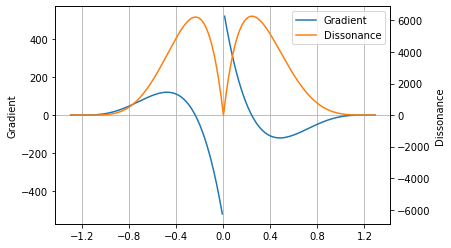

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

f2 = 440
critical_bandwidth = cbw(f2)
phon1 = phon(1, f2)
volume_factor = phon1 * phon1
f1s = np.arange(-1.3, 1.3, 0.01)
diss = np.vectorize(lambda f1: frankenstein_basic_dissonance(f1, f2, 1, 1))(critical_bandwidth*f1s+f2)
# np.nan at the point of discontinuity to plot the discontinuity correctly
grad = np.vectorize(lambda f1: simple_grad(f1, f2, critical_bandwidth, volume_factor) if abs(f1-f2) > 1. else np.nan)(critical_bandwidth*f1s+f2)

ln1 = ax1.plot(f1s, grad, '#1f77b4', label='Gradient')
ln2 = ax2.plot(f1s, diss, '#ff7f0e', label='Dissonance')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

ax1.set_ylim(-np.max(np.abs(grad[np.logical_not(np.isnan(grad))])) * 1.1, np.max(np.abs(grad[np.logical_not(np.isnan(grad))])) * 1.1)
ax2.set_ylim(-np.max(np.abs(diss)) * 1.1,np.max(np.abs(diss)) * 1.1)

ax1.set_ylabel("Gradient")
ax2.set_ylabel("Dissonance")

ax1.set_xticks([-1.2, -0.8, -0.4, 0.0, 0.4, 0.8, 1.2])
ax1.xaxis.grid(True)

# the only way I could get a single gridline at 0 but all ticks
# cannot be exactly 0 because otherwise the invisible major tick
# at 0 will somehow mask it...
ax1.set_yticks([0.1], minor=True)
ax1.tick_params(axis='y', which='minor')
ax1.yaxis.grid(b=True, which='minor')
#ax2.grid(True)

## Definition

In [27]:
def frankenstein_dissonance_grad(fundamentals, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs):
    # Returns dissonance and gradient of dissonance with respect to the fundamentals
    
    # frequencies of fundamentals are given in absolute values (Hz) in fundamentals
    # frequencies of partials are given relative the the fundamental frequency
    # e.g. [1,2] means that the complex tones are made up of 2 partials: the fundamental and the octave
    # fixed pos are the absolute freqs of the fixed simple tones
    
    # a row corresponds to a complex tone
    positions = np.outer(fundamentals, partials_pos)
    
    # all relevant pairs of frequencies of partials
    args = np.array([
        [positions[i,k], positions[j,l]] if l >= 0 else [positions[i,k], fixed_pos[j]]
        for (i, k, j, l) in relevant_pairs
    ])
    try:
        p1s = args[:,0]
        p2s = args[:,1]
    except IndexError:
        print("No relevant pairs!")
        return 0, np.zeros(len(fundamentals))
    
    hs = np.abs(p1s - p2s) / critical_bandwidths
    
    cond = np.where(hs < 1.2)
    relevant_pairs = relevant_pairs[cond]
    p1s = p1s[cond]
    p2s = p2s[cond]
    hs = hs[cond]
    volume_factors = volume_factors[cond]
    critical_bandwidths = critical_bandwidths[cond]
    
    ds = 4.906 * hs * (hs - 1.2)**4
    
    total_dissonance = np.sum(ds * volume_factors)
    
    # calculate gradient:
    dhdcs = volume_factors \
            * 4.906 * (hs - 1.2)**3 * (5 * hs - 1.2) \
            * np.where(p1s > p2s, np.ones(len(p1s)), -1 * np.ones(len(p1s))) / critical_bandwidths
    
    # positions of the partials of the relevant pairs relative to their fundamental,
    # partials_pos should be a np.array
    try:
        r1s = partials_pos[relevant_pairs[:,1]]
        r2s = np.where(relevant_pairs[:,3] >= 0, partials_pos[relevant_pairs[:,3]], 0.)
    except TypeError:
        partials_pos = np.array(partials_pos)
        r1s = partials_pos[relevant_pairs[:,1]]
        r2s = np.where(relevant_pairs[:,3] >= 0, partials_pos[relevant_pairs[:,3]], 0.)
    
    # gradients with respect to fundamental of the first and the second partial of the pair
    simple_grads1 = dhdcs * r1s
    simple_grads2 = dhdcs * r2s
    
    # sum all simple gradients where complex tone i is involved
    gradient = np.array([np.sum(simple_grads1[relevant_pairs[:,0] == i]) 
                         - np.sum(simple_grads2[relevant_pairs[:,2] == i])
                for i in range(len(fundamentals))])
    
    return total_dissonance, gradient

In [28]:
def optimize_grad(fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos = [], fixed_vol = [],
             method = "SLSQP", relative_bounds = (2**(-1/36), 2**(1/36)), maxiter = None):
    
    partials_pos = np.array(partials_pos)  # frankenstein_dissonance_grad needs a np.array
    
    critical_bandwidths, volume_factors, relevant_pairs = quasi_constants(
        fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos, fixed_vol)
    
    bounds = [(f * relative_bounds[0], f * relative_bounds[1]) for f in fundamentals]
    if maxiter is None:
        options = {}
    else:
        options = {'maxiter': maxiter}
    
    res = scipy.optimize.minimize(
        lambda fs: frankenstein_dissonance_grad(
            fs, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs),
        fundamentals,
        method=method,
        bounds=bounds,
        options=options,
        jac=True
    )
    
    return res

In [29]:
# check if my gradient is correct:

# Construct example arguments, tuning of A maj, tonic fixed:
notes = [0, 12.01, 5,2]
fundamentals = [440 * 2**(i/12) for i in notes]
fundamentals_vol = np.ones(len(fundamentals))
partials_pos = list(range(1, len(partials_vol_piano[:]) + 1))
partials_vol = partials_vol_piano[:]

fixed_pos = [fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]
fundamentals = fundamentals[1:]
fundamentals_vol = fundamentals_vol[1:]

critical_bandwidths, volume_factors, relevant_pairs = quasi_constants(
        fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos, fixed_vol)


func = lambda fs: frankenstein_dissonance_grad(fs, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[0]
grad = lambda fs: frankenstein_dissonance_grad(fs, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[1]

epsilon = 0.001

print("Dissonance:     ", frankenstein_dissonance_grad(fundamentals, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[0])
print("Gradient:       ", frankenstein_dissonance_grad(fundamentals, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[1])
print("Approx Gradient:", scipy.optimize.approx_fprime(fundamentals, func, epsilon=epsilon))
print("Error:          ", scipy.optimize.check_grad(func, grad, fundamentals, epsilon=epsilon))

Dissonance:      123388.856240408
Gradient:        [ 916.52983655 2004.00048035 -775.84988154]
Approx Gradient: [ 916.46473583 2003.88519783 -775.91395727]
Error:           0.1470845424810585


# Hutchinson Gradient

## Preparation

Same as above but using roughness of Hutchinson:

$d_{i,j,k,l} = 16 h^2 \exp(2 - 8 h)$

$\frac{\delta}{\delta f_c}d_{c,j,k,l} = 32 h \exp(2 - 8 h) (1 - 4 h) \frac{\delta}{\delta f_c} h_{c,j,k,l}$

This results in a continuous gradient.

In [30]:
def frankenstein_basic_dissonance_hutch(p1, p2, v1, v2):
    mean = (p1 + p2) / 2
    critical_bandwidth = 25 + 75 * (1 + 1.4e-6 * mean**2)**0.69  # taken from Dillon
    h = abs(p1 - p2) / critical_bandwidth
    
    # taken from Hutchinson, other than dillon, this is continously differentiable for h = 0
    d = 16 * h**2 * np.exp(2 - 8 * h)

    # translate v1, v2 to phon, similar to what I used in my Bernini implementation
    # but simplified and optimized (see Component Evaluation)
    # f much simpler
    v1 = np.log(1 + v1**8.685889 * np.exp(86 - 914.327 * p1**-0.8 - 1e-15 * p1**4))
    v2 = np.log(1 + v2**8.685889 * np.exp(86 - 914.327 * p2**-0.8 - 1e-15 * p2**4))
    f = v1 * v2
    
    return d * f

def frankenstein_dissonance_hutch(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol,
                               frankenstein_basic_dissonance_hutch)

In [31]:
def simple_grad_hutch(f1, f2, critical_bandwidth, volume_factor):
    if f1 > f2:
        dhdf1 = 1 / critical_bandwidth
    elif f2 > f1:
        dhdf1 = -1 / critical_bandwidth
    else:
        return 0.
    
    h = abs(f1 - f2) / critical_bandwidth
    dddf1 = 32 * h * np.exp(2 - 8 * h) * (1 - 4 * h) * dhdf1
    
    return dddf1 * volume_factor

In [32]:
# check if my gradient is correct:

f1 = 440
f2 = 450
volume_factor = phon(1, f1) * phon(1, f2)
critical_bandwidth = cbw((f1 + f2) / 2)

func = lambda f: frankenstein_basic_dissonance_hutch(f[0], f2, 1, 1)
grad = lambda f: simple_grad_hutch(f[0], f2, critical_bandwidth, volume_factor)

epsilon = 0.0000001

print("Dissonance:    ", frankenstein_basic_dissonance_hutch(f1, f2, 1, 1))
print("Gradient:      ", simple_grad_hutch(f1, f2, critical_bandwidth, volume_factor))
print("Approx Gradient", scipy.optimize.approx_fprime([f1], func, epsilon=epsilon))
print("Error          ", scipy.optimize.check_grad(func, grad, [f1], epsilon=epsilon))

Dissonance:     2824.012110205346
Gradient:       -366.26898335033184
Approx Gradient [-366.77459775]
Error           0.5056144005866372


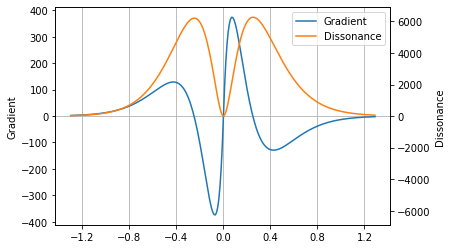

In [33]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

f2 = 440
critical_bandwidth = cbw(f2)
phon1 = phon(1, f2)
volume_factor = phon1 * phon1
f1s = np.arange(-1.3, 1.3, 0.01)
diss = np.vectorize(lambda f1: frankenstein_basic_dissonance_hutch(f1, f2, 1, 1))(critical_bandwidth*f1s+f2)
grad = np.vectorize(lambda f1: simple_grad_hutch(f1, f2, critical_bandwidth, volume_factor))(critical_bandwidth*f1s+f2)

ln1 = ax1.plot(f1s, grad, '#1f77b4', label='Gradient')
ln2 = ax2.plot(f1s, diss, '#ff7f0e', label='Dissonance')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

ax1.set_ylim(-np.max(np.abs(grad)) * 1.1,np.max(np.abs(grad)) * 1.1)
ax2.set_ylim(-np.max(np.abs(diss)) * 1.1,np.max(np.abs(diss)) * 1.1)

ax1.set_xticks([-1.2, -0.8, -0.4, 0.0, 0.4, 0.8, 1.2])
ax1.xaxis.grid(True)

ax1.set_ylabel("Gradient")
ax2.set_ylabel("Dissonance")

# the only way I could get a single gridline at 0 but all ticks
# cannot be exactly 0 because otherwise the invisible major tick
# at 0 will somehow mask it...
ax1.set_yticks([0.01], minor=True)
ax1.tick_params(axis='y', which='minor')
ax1.yaxis.grid(b=True, which='minor')
#ax2.grid(True)

## Definition

In [34]:
def frankenstein_dissonance_grad_hutch(fundamentals, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs):
    # Returns dissonance and gradient of dissonance with respect to the fundamentals
    
    # frequencies of fundamentals are given in absolute values (Hz) in fundamentals
    # frequencies of partials are given relative the the fundamental frequency
    # e.g. [1,2] means that the complex tones are made up of 2 partials: the fundamental and the octave
    # fixed pos are the absolute freqs of the fixed simple tones
    
    # a row corresponds to a complex tone
    positions = np.outer(fundamentals, partials_pos)
    
    # all relevant pairs of frequencies of partials
    args = np.array([
        [positions[i,k], positions[j,l]] if l >= 0 else [positions[i,k], fixed_pos[j]]
        for (i, k, j, l) in relevant_pairs
    ])
    try:
        p1s = args[:,0]
        p2s = args[:,1]
    except IndexError:
        print("No relevant pairs!")
        return 0, np.zeros(len(fundamentals))
    
    hs = np.abs(p1s - p2s) / critical_bandwidths
    
    ds = 16 * hs**2 * np.exp(2 - 8 * hs)
    
    total_dissonance = np.sum(ds * volume_factors)
    
    # calculate gradient:
    dhdcs = volume_factors \
            * 32 * hs * np.exp(2 - 8 * hs) * (1 - 4 * hs) \
            * np.where(p1s > p2s, np.ones(len(p1s)), -1 * np.ones(len(p1s))) / critical_bandwidths
    
    # positions of the partials of the relevant pairs relative to their fundamental,
    # partials_pos should be a np.array
    try:
        r1s = partials_pos[relevant_pairs[:,1]]
        r2s = np.where(relevant_pairs[:,3] >= 0, partials_pos[relevant_pairs[:,3]], 0.)
    except TypeError:
        partials_pos = np.array(partials_pos)
        r1s = partials_pos[relevant_pairs[:,1]]
        r2s = np.where(relevant_pairs[:,3] >= 0, partials_pos[relevant_pairs[:,3]], 0.)
    
    # gradients with respect to fundamental of the first and the second partial of the pair
    simple_grads1 = dhdcs * r1s
    simple_grads2 = dhdcs * r2s
    
    # sum all simple gradients where complex tone i is involved
    gradient = np.array([np.sum(simple_grads1[relevant_pairs[:,0] == i]) 
                         - np.sum(simple_grads2[relevant_pairs[:,2] == i])
                for i in range(len(fundamentals))])
    
    return total_dissonance, gradient

In [35]:
def optimize_grad_hutch(fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos = [], fixed_vol = [],
             method = "SLSQP", relative_bounds = (2**(-1/36), 2**(1/36)), maxiter = None):
    
    partials_pos = np.array(partials_pos)  # frankenstein_dissonance_grad needs a np.array
    
    critical_bandwidths, volume_factors, relevant_pairs = quasi_constants(
        fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos, fixed_vol)
    
    bounds = [(f * relative_bounds[0], f * relative_bounds[1]) for f in fundamentals]
    if maxiter is None:
        options = {}
    else:
        options = {'maxiter': maxiter}
    
    res = scipy.optimize.minimize(
        lambda fs: frankenstein_dissonance_grad_hutch(
            fs, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs),
        fundamentals,
        method=method,
        bounds=bounds,
        options=options,
        jac=True
    )
    
    return res

In [36]:
# check if my gradient is correct:

# Construct example arguments, tuning of A maj, tonic fixed:
notes = [0, 12.01, 5, 2]
fundamentals = [440 * 2**(i/12) for i in notes]
fundamentals_vol = np.ones(len(fundamentals))
partials_pos = list(range(1, len(partials_vol_piano[:]) + 1))
partials_vol = partials_vol_piano[:]

fixed_pos = [fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]
fundamentals = fundamentals[1:]
fundamentals_vol = fundamentals_vol[1:]

critical_bandwidths, volume_factors, relevant_pairs = quasi_constants(
        fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos, fixed_vol)


func = lambda fs: frankenstein_dissonance_grad_hutch(fs, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[0]
grad = lambda fs: frankenstein_dissonance_grad_hutch(fs, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[1]

epsilon = 0.00001

print("Dissonance:     ", frankenstein_dissonance_grad_hutch(fundamentals, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[0])
print("Gradient:       ", frankenstein_dissonance_grad_hutch(fundamentals, partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[1])
print("Approx Gradient:", scipy.optimize.approx_fprime(fundamentals, func, epsilon=epsilon))
print("Error:          ", scipy.optimize.check_grad(func, grad, fundamentals, epsilon=epsilon))

Dissonance:      118634.23462108063
Gradient:        [   6.88816271   89.73728915 -639.17712323]
Approx Gradient: [   6.89009321   89.73951917 -639.17737862]
Error:           0.00296058022881065


# Some Plots: Dillon vs. Hutchinson

Getting to know the shape we are trying to navigate...

In [37]:
# amplitudes of the piano-synth I defined in sc3
partials_vol_piano = np.array([3.7, 5.4, 1.2, 1.1, 0.95, 0.6, 0.5, 0.65, 0.001, 0.1, 0.2]) / 5.4

# partials with harmonic decline (I read somewhere that that's a violin)
partials_vol_harm = [1 / i for i in range(1,12)]

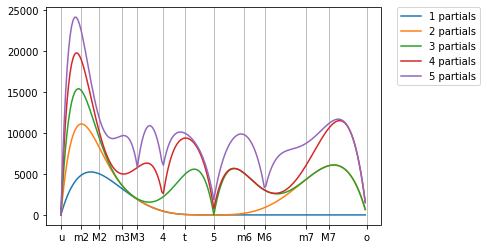

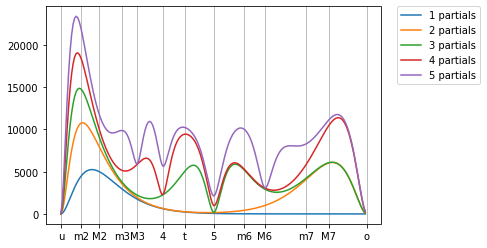

In [38]:
plot_dissonance(frankenstein_dissonance_vec, nr_partials=range(1,6), partials_vol=partials_vol_piano)
plot_dissonance(frankenstein_dissonance_hutch, nr_partials=range(1,6), partials_vol=partials_vol_piano)

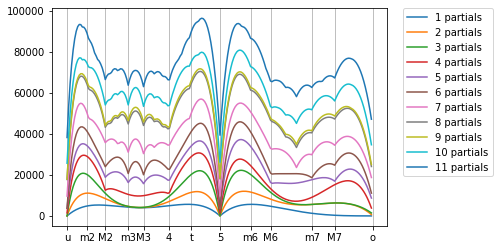

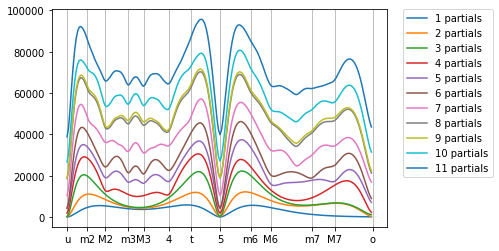

In [39]:
# finding a third tone when tonic and fifths are already sounding
plot_dissonance(
    lambda fundamentals, fundamentals_vol, partials_pos, partials_vol: frankenstein_dissonance_vec(fundamentals+[fundamentals[0]*1.5], [1,1,1], partials_pos, partials_vol),
    nr_partials=range(1,12), partials_vol=partials_vol_piano
)
plot_dissonance(
    lambda fundamentals, fundamentals_vol, partials_pos, partials_vol: frankenstein_dissonance_hutch(fundamentals+[fundamentals[0]*1.5], [1,1,1], partials_pos, partials_vol),
    nr_partials=range(1,12), partials_vol=partials_vol_piano
)

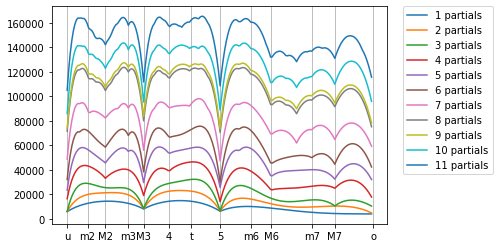

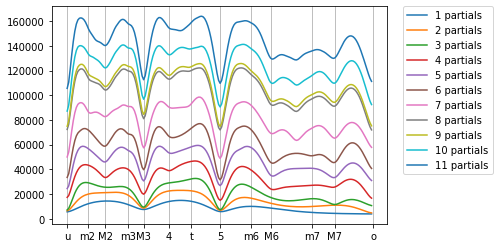

In [40]:
# finding a fourths tone when tonic and fifths and JU maj third are already sounding
plot_dissonance(
    lambda fundamentals, fundamentals_vol, partials_pos, partials_vol: frankenstein_dissonance_vec(fundamentals+[fundamentals[0]*1.5, fundamentals[0]*5/4], [1,1,1,1], partials_pos, partials_vol),
    nr_partials=range(1,12), partials_vol=partials_vol_piano
)
plot_dissonance(
    lambda fundamentals, fundamentals_vol, partials_pos, partials_vol: frankenstein_dissonance_hutch(fundamentals+[fundamentals[0]*1.5, fundamentals[0]*5/4], [1,1,1,1], partials_pos, partials_vol),
    nr_partials=range(1,12), partials_vol=partials_vol_piano
)

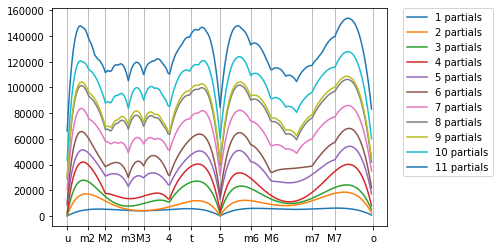

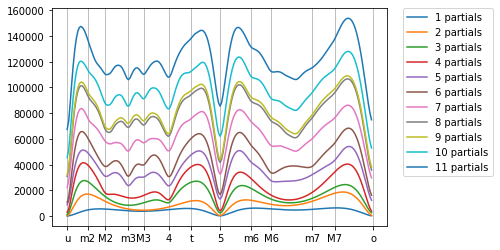

In [41]:
# finding a fourth tone when tonic and fifths and octave are already sounding
plot_dissonance(
    lambda fundamentals, fundamentals_vol, partials_pos, partials_vol: frankenstein_dissonance_vec(fundamentals+[fundamentals[0]*1.5, fundamentals[0]*2], [1,1,1,1], partials_pos, partials_vol),
    nr_partials=range(1,12), partials_vol=partials_vol_piano
)
plot_dissonance(
    lambda fundamentals, fundamentals_vol, partials_pos, partials_vol: frankenstein_dissonance_hutch(fundamentals+[fundamentals[0]*1.5, fundamentals[0]*2], [1,1,1,1], partials_pos, partials_vol),
    nr_partials=range(1,12), partials_vol=partials_vol_piano
)

# Tests

## Dillon

In [42]:
ji_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]

In [43]:
# RESULTS:
# Methods L-BFGS-B, SLSQP, trust-constr, TNC all support bounds and gradient and yield reasonable tunings sometimes.
# Number of Iterations they need to tune a equal tempered min7 chord nearly as good as just intonation
# i.e. dissonance(res.x) < dissonance(ji_fundamentals) + 2.
# without gradients:
# L-BFGS-B: can't do it, SLSQP: 14 , trust-constr: 62, TNC: can't do it
# with gradients:
# L-BFGS-B: 19 , SLSQP: 14 , trust-constr: 57, TNC: can't do it
# This will be used later to compare computation times

# Same test for maj with octave:
# without gradients:
# L-BFGS-B: 21, SLSQP: 17 , trust-constr: 35, TNC: can't do it
# with gradients:
# L-BFGS-B can't do it , SLSQP: 14 , trust-constr: 41, TNC: can't do it

# Same test for maj add 6:
# without gradients:
# L-BFGS-B: 27, SLSQP: 15 , trust-constr: 68, TNC: can't do it
# with gradients:
# L-BFGS-B can't do it , SLSQP: 16 , trust-constr: 65, TNC: can't do it


# same test but lowest tone fixed to prevent pitch drift
notes = [0, 4, 7, 12]
et_fundamentals = [440 * 2**(i/12) for i in notes]
ji_fundamentals = [440 * ji_intervals[i] for i in notes]
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_piano
relative_bounds = (2**(-1/24), 2**(1/24))

dissonance = lambda fs: frankenstein_dissonance_vec(
        np.append(fs, et_fundamentals[0]), np.ones(len(fs)+1), partials_pos, partials_vol)

level = 2  # level of optimization of the optimization algorithm
method = "L-BFGS-B"
iterations = 21

if level == 3:
    # optimization of the dissonance curve with gradient information
    fixed_pos = [et_fundamentals[0] * p for p in partials_pos]
    fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]
    res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, method, relative_bounds, iterations)
    res.x = np.append(et_fundamentals[0], res.x)
elif level == 2:
    # optimization of the dissonance curve optimized for optimization, without gradient information
    fixed_pos = [et_fundamentals[0] * p for p in partials_pos]
    fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]
    res = optimize(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, method, relative_bounds, iterations)
    res.x = np.append(et_fundamentals[0], res.x)
elif level == 1:
    # simple optimization of the dissonance function
    dissonance = lambda fs: frankenstein_dissonance_vec(
        np.append(fs, et_fundamentals[0]), np.ones(len(fs)+1), partials_pos, partials_vol)
    res = scipy.optimize.minimize(dissonance, et_fundamentals[1:], method=method, bounds=[(f * relative_bounds[0], f * relative_bounds[1]) for f in et_fundamentals[1:]])
    res.x = np.append(et_fundamentals[0], res.x)

In [44]:
dissonance(res.x) < dissonance(ji_fundamentals) + 2.

True

In [45]:
res

      fun: 119737.55085822644
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  915.74911494, -2233.36246563,  2519.66703217])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 156
      nit: 21
   status: 1
  success: False
        x: array([440.        , 550.00006264, 659.99986079, 880.00014641])

In [46]:
# aim: dissonance of res.x should be at laest as good as dissonance of the ju-intervals,
# otherwise I could just use static JU
dissonance(res.x), dissonance(et_fundamentals), dissonance(ji_fundamentals)

(171306.04598286338, 183983.5367316582, 171304.81961714418)

In [47]:
print([f/res.x[0] for f in res.x])
print([f/et_fundamentals[0] for f in et_fundamentals])
print([f/ji_fundamentals[0] for f in ji_fundamentals])

[1.0, 1.250000142352558, 1.4999996836148828, 2.000000332739056]
[1.0, 1.259921049894873, 1.4983070768766815, 2.0]
[1.0, 1.25, 1.5, 2.0]


## Hutchinson

In [48]:
ji_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]

In [49]:
# RESULTS:
# turns out it realy helps to have a continuously differentiable objective function!

# Methods L-BFGS-B, SLSQP, trust-constr, TNC all support bounds and gradient and yield reasonable tunings sometimes.
# Number of Iterations they need to tune a equal tempered min7 chord nearly as good as just intonation
# i.e. dissonance(res.x) < dissonance(ji_fundamentals) + 2.
# without gradients:
# with gradients:
# L-BFGS-B: 5 , SLSQP: 5 , trust-constr: 6, TNC: 13
# This will be used later to compare computation times

# Same test for maj with octave:
# with gradients:
# L-BFGS-B: 4 , SLSQP: 6 , trust-constr: 3, TNC: 15

# Same test for maj add 6:
# with gradients:
# L-BFGS-B: 3 , SLSQP: 4 , trust-constr: 4, TNC: 13

notes = [0, 3, 7, 10]
et_fundamentals = [440 * 2**(i/12) for i in notes]
ji_fundamentals = [440 * ji_intervals[i] for i in notes]
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_piano
relative_bounds = (2**(-1/24), 2**(1/24))

fixed_pos = [et_fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]

critical_bandwidths, volume_factors, relevant_pairs = quasi_constants(
        et_fundamentals, fundamentals_vol, partials_pos, partials_vol, fixed_pos, fixed_vol)
dissonance = lambda fs: frankenstein_dissonance_grad_hutch(
        np.append(fs, et_fundamentals[0]), partials_pos, fixed_pos, critical_bandwidths, volume_factors, relevant_pairs)[0]

method = "TNC"
iterations = 13

# optimization of the dissonance curve with gradient information
res = optimize_grad_hutch(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, method, relative_bounds, iterations)
res.x = np.append(et_fundamentals[0], res.x)


In [50]:
dissonance(res.x) < dissonance(ji_fundamentals) + 2.

True

In [51]:
res

     fun: 132013.78492033633
     jac: array([-163.56683914,   23.34923381,   36.0471233 ])
 message: 'Max. number of function evaluations reached'
    nfev: 13
     nit: 4
  status: 3
 success: False
       x: array([440.        , 528.15144677, 660.46135204, 792.46550352])

In [52]:
# aim: dissonance of res.x should be at laest as good as dissonance of the ju-intervals,
# otherwise I could just use static JU
dissonance(res.x), dissonance(et_fundamentals), dissonance(ji_fundamentals)

(200328.07985468005, 203309.13692389213, 200371.9966147113)

In [53]:
[f/res.x[0] for f in res.x]

[1.0, 1.200344197207381, 1.501048527353613, 1.8010579625419518]

# Test Performance

## Naive optimization of the target function vs. optimized optimization

In [54]:
notes = [0, 4, 7, 12]
et_fundamentals = [440 * 2**(i/12) for i in notes]
ji_fundamentals = [440 * ji_intervals[i] for i in notes]
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_piano
relative_bounds = (2**(-1/24), 2**(1/24))
dissonance = lambda fs: frankenstein_dissonance_vec(
    np.append(fs, et_fundamentals[0]), np.ones(len(fs)+1), partials_pos, partials_vol)

%timeit res = scipy.optimize.minimize(dissonance, et_fundamentals[1:], method="SLSQP", bounds=[(f * relative_bounds[0], f * relative_bounds[1]) for f in et_fundamentals[1:]])
%timeit res = scipy.optimize.minimize(dissonance, et_fundamentals[1:], method="SLSQP", bounds=[(f * relative_bounds[0], f * relative_bounds[1]) for f in et_fundamentals[1:]])
%timeit res = scipy.optimize.minimize(dissonance, et_fundamentals[1:], method="SLSQP", bounds=[(f * relative_bounds[0], f * relative_bounds[1]) for f in et_fundamentals[1:]])

457 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
447 ms ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
447 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
notes = [0, 4, 7, 12]
et_fundamentals = [440 * 2**(i/12) for i in notes]
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_piano
relative_bounds = (2**(-1/36), 2**(1/36))

fixed_pos = [et_fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]

%timeit res = optimize(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, "SLSQP", relative_bounds)
%timeit res = optimize(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, "SLSQP", relative_bounds)
%timeit res = optimize(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, "SLSQP", relative_bounds)

137 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
142 ms ± 7.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
160 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Comparison of scipy methods, with/without gradient, Dillon vs. Hutchinson

To compare the different settings, I checked in the last chapter how many iterations they need to tune a equal tempered major chord nearly as good as just intonation (iter_no_grad and iter_grad). In this chapter I check how long it takes for the different settings to complete that number of iterations.

In [56]:
# Dillon

notes = [0, 3, 7, 10]
et_fundamentals = [440 * 2**(i/12) for i in notes]
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_harm
relative_bounds = (2**(-1/36), 2**(1/36))

fixed_pos = [et_fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]

methods = ["L-BFGS-B", "SLSQP", "trust-constr"]
iter_no_grad = [100, 14 , 62]  # 100 iterations for the methods that can't do it, see above "Tests"
iter_grad = [19, 14 , 57]

for i in range(len(methods)):
    print(methods[i], " no gradient:")
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_no_grad[i])
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_no_grad[i])
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_no_grad[i])
    print()
    print(methods[i], " with gradient:")
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_grad[i])
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_grad[i])
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_grad[i])
    print()

L-BFGS-B  no gradient:
82.7 ms ± 821 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
82.2 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
81.7 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

L-BFGS-B  with gradient:
55.8 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.2 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.2 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SLSQP  no gradient:
47.3 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.2 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.5 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SLSQP  with gradient:
47.7 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.5 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.1 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

trust-constr  no gradient:
587 ms ± 5.46 ms per loop (m

In [57]:
# Hutchinson

notes = [0, 3, 7, 10]
et_fundamentals = [440 * 2**(i/12) for i in notes]
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_harm
relative_bounds = (2**(-1/36), 2**(1/36))

fixed_pos = [et_fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]

methods = ["L-BFGS-B", "SLSQP", "trust-constr", "TNC"]
iter_grad = [5, 5, 6, 13]

for i in range(len(methods)):
    print(methods[i], " with gradient:")
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_grad[i])
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_grad[i])
    %timeit res = optimize_grad(et_fundamentals[1:], fundamentals_vol[1:], partials_pos, partials_vol, fixed_pos, fixed_vol, methods[i], relative_bounds, iter_grad[i])
    print()

L-BFGS-B  with gradient:
15.5 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.5 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.6 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

SLSQP  with gradient:
24.7 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.9 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

trust-constr  with gradient:
50.4 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.1 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.2 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

TNC  with gradient:
17.5 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.6 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.5 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

